This notebook shows the data exploration and prediction for patients from city of Vitória - State of Espírito Santo located
in Brazil.
The dataset contains information about the patients. Some of the features that are present are age, gender, date of appointment, date of scheduling the appointment, number of disabilities a patient has and so on. Using these features , we would be finding out what factors influence more people to not show up for their appointment.
We would also use 3 classifiers to predict if a patient would miss his appointment or not.


In [142]:
import pandas as pd
import numpy as np
import datetime
import calendar
pd.options.mode.chained_assignment = None
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score
import seaborn as sns
sns.set_style("whitegrid")
sns.set(color_codes=True)


In [143]:
#Reading the file
df_data = pd.read_csv('KaggleV2-May-2016.csv')
df = df_data


In [144]:
import matplotlib
matplotlib.rcParams.update({'font.size': 22})

Here we would plot the various features and see how they are distributed

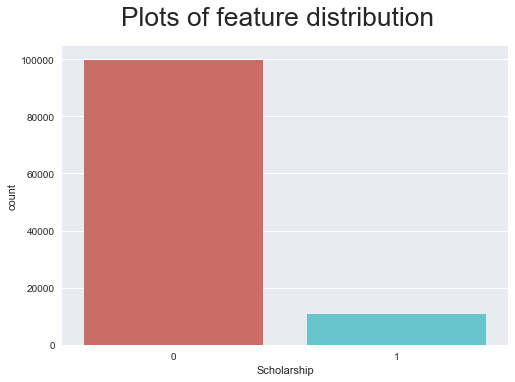

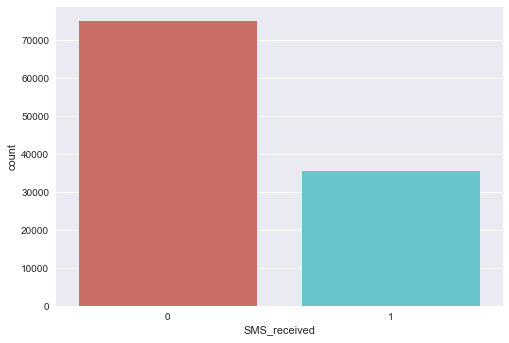

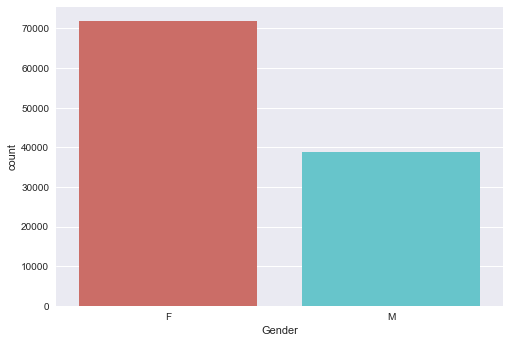

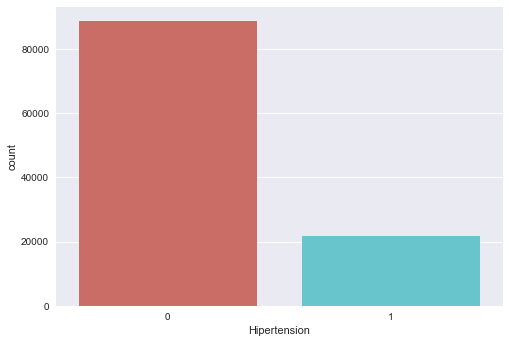

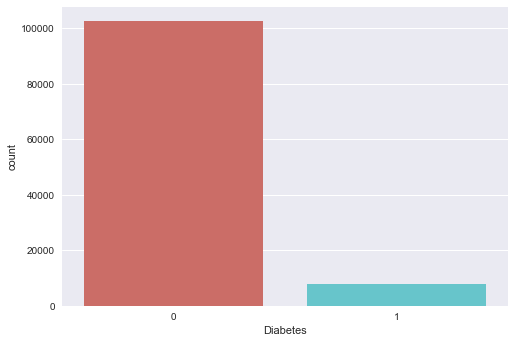

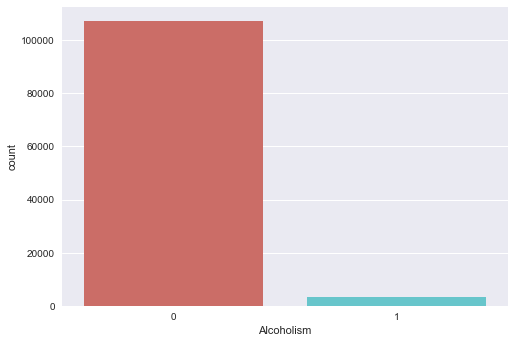

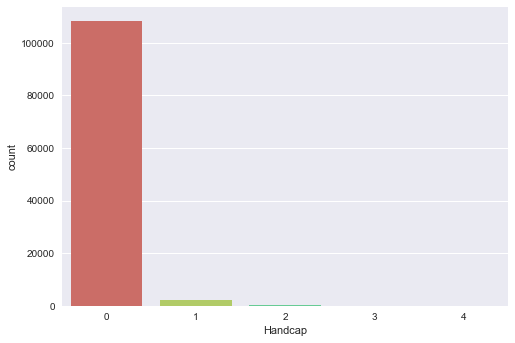

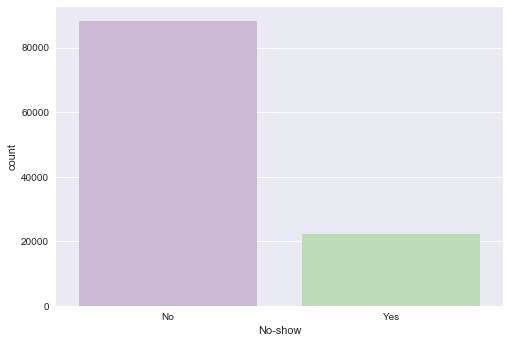

In [145]:
#Exploratory analysis
sns.plt.suptitle('Plots of feature distribution')

sns.countplot(x='Scholarship', data=df, palette='hls')
sns.plt.show()

sns.countplot(x='SMS_received', data=df, palette='hls')
sns.plt.show()

sns.countplot(x='Gender', data=df, palette='hls')
sns.plt.show()

sns.countplot(x='Hipertension', data=df, palette='hls')
sns.plt.show()

sns.countplot(x='Diabetes', data=df, palette='hls')
sns.plt.show()

sns.countplot(x='Alcoholism', data=df, palette='hls')
sns.plt.show()

sns.countplot(x='Handcap', data=df, palette='hls')
sns.plt.show()

# Check the balance of the data

sns.countplot(x='No-show',data=df_data,palette='PRGn')


This shows that almost 80% of time patient shows up for appointment

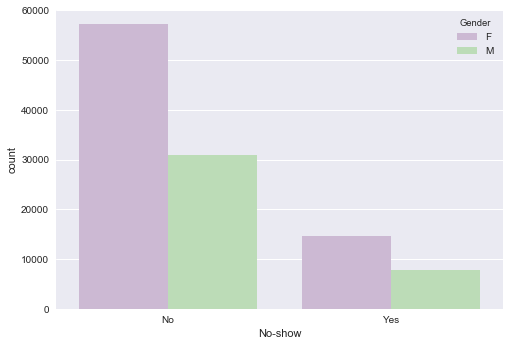

In [146]:
# Show - No-show trend among the gender groups

sns.countplot(x='No-show', hue='Gender', data=df_data, palette='PRGn')

Data Pre-processing: 

In [147]:
#Renaming Feature Names
df = df.rename(columns={'Hipertension': 'Hypertension', 'Handcap': 'Handicap', 'No-show' : 'Status'})

In [148]:
# Code 0 for Show and 1 for No-Show

df['Status'].replace("No", 0,inplace=True)
df['Status'].replace("Yes",1,inplace=True)

Feature Transformation

In [149]:
#extract PatientID and transform it to simpler IDs
df['NewPatientId'] = 0
df_sorted=df.sort_values(by=['PatientId'])
df_PatientID = df_sorted['PatientId']
df_sorted['PatientId'].values.ravel()
names = pd.unique(df_sorted['PatientId'].values.ravel())
names = pd.Series(np.arange(1,len(names)+1), names)
df_new_ids = df_sorted.applymap(names.get)
df_sorted['NewPatientId'] = df_new_ids['PatientId']
df_sorted['PatientId'] = df_sorted['NewPatientId']
del df_sorted['NewPatientId']

In [150]:
#Take age only in the range 0-105
df_sorted = df_sorted[(df_sorted.Age >= 0) & (df_sorted.Age <= 105)]

In [151]:
#Calculate Day of the Week when the appointment is.
my_date = df_sorted[['AppointmentDay']]
#print(my_date)
my_date['AppointmentDay'] = pd.to_datetime(my_date['AppointmentDay'])
my_date['day_of_week'] = my_date['AppointmentDay'].dt.weekday_name
#print(my_date)
df_sorted['DayofWeek'] = my_date['day_of_week']

In [152]:
#Calculate HourOfTheDay
df = df_sorted
df['HourOfTheDay'] = df['ScheduledDay'].apply(lambda x: int(x[11:13]))

Wait_Time is the difference between the appointment day and the scheduled day. We have taken the absolute value of the wait time as some of the dates were negative. We have assumed that they were swapped by mistake during the entry in records at the hospital

In [153]:
#To Calculate Waiting Time

df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['Wait_Time'] = df['AppointmentDay'] - df['ScheduledDay']

time_array = []
for time in df['Wait_Time']:
    time_array.append(abs(time.days))

df['Wait_Time'] = time_array

Multiple Chronics is the addition of all the chronic ailments the patient is suffering from.

In [155]:
#MultipleChronics
df['MultipleChronics'] = np.where((df['Hypertension']+df['Diabetes']+df['Alcoholism']+df['Handicap'])>1,1,0)

As their are 81 unique neighborhoods, we gave each neighborhood a unique number called Labeled_Neighbourhood that 
starts from 1 and goes till 81

In [156]:
#Labeled_Neighbourhood
df['Labeled_Neighbourhood'] = pd.factorize(df.Neighbourhood)[0] + 1

DayofWeek gives a numeric value to the actual days in a week. This is helpful for the input in classifiers.

In [157]:
df['DayofWeek'] = pd.factorize(df.DayofWeek)[0] + 1

Now we calculate total Number of Appointments Missed by Patient. This served as a very important feature for the classifier

In [158]:
# Number of Appointments Missed by Patient
df['Num_App_Missed'] = df.groupby('PatientId')['Status'].apply(lambda x: x.cumsum())

In [159]:
#Feature selection PatientId, Gender, Age, Neighbourhood, Scholarship, Hypertension, Diabetes, Alcoholism,Handicap,SMS_received,Status,DayofWeek	HourOfTheDay	Wait_Time	MultipleChornics	Labeled_Neighbourhood
df_final = df[['PatientId', 'Gender', 'Age', 'Neighbourhood', 'Scholarship' , 'Hypertension' , 'Diabetes','Alcoholism', 
              'Handicap','SMS_received','Status','DayofWeek' ,'HourOfTheDay' ,'Wait_Time','MultipleChronics', 
               'Labeled_Neighbourhood','Num_App_Missed']].copy()


Data Visualization

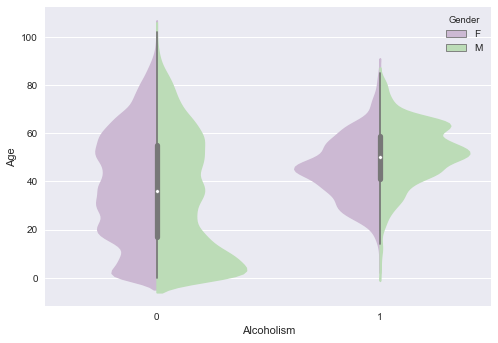

In [160]:
# Alcoholism trend by Age for the two groups Male and Female

sns.violinplot(x='Alcoholism',y='Age',hue='Gender',data=df_final, palette='PRGn',split=True)

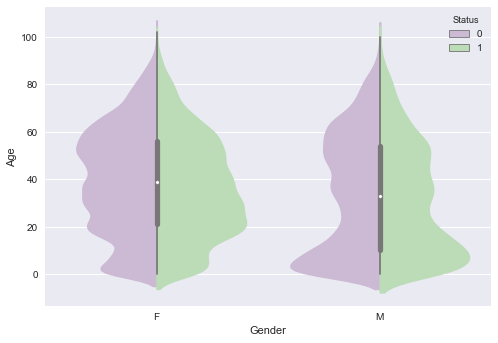

In [161]:
# Visualization of the trend for show-no-show by age and gender

sns.violinplot(x='Gender',y='Age',hue='Status',data=df_final, palette='PRGn',split=True)


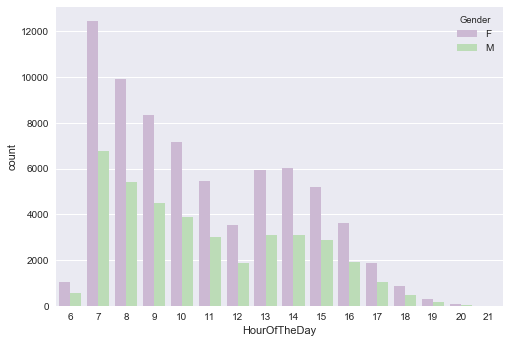

In [162]:
# Trend for preference of the hour of day by gender

sns.countplot(x='HourOfTheDay', data=df_final, hue='Gender',palette='PRGn')

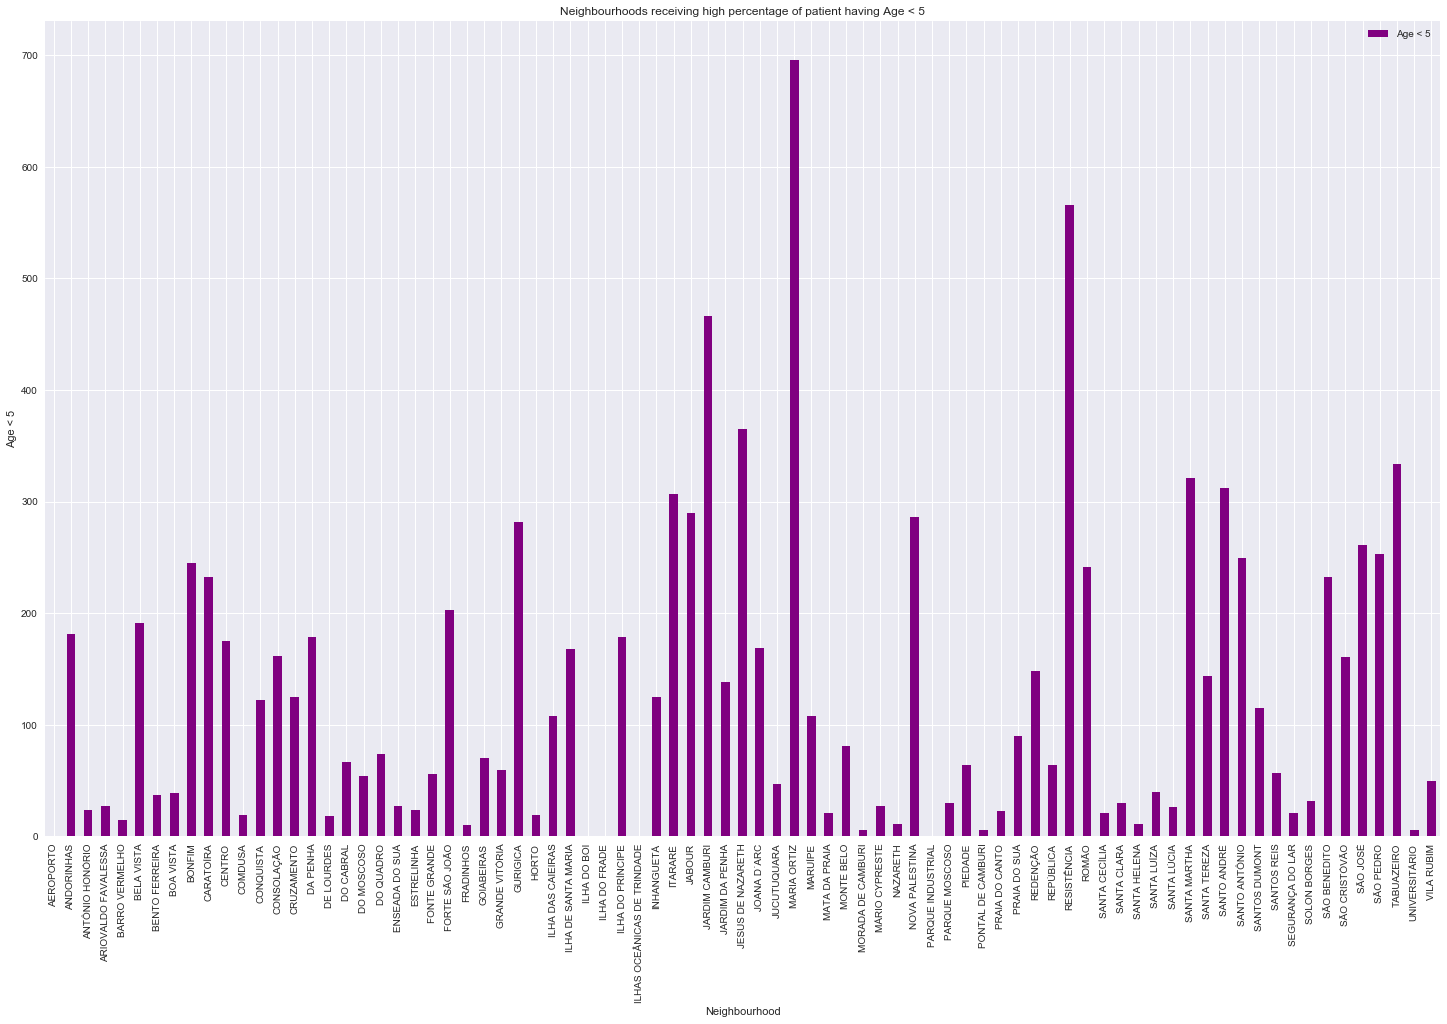

In [163]:
df_final['Age < 5']= (df_final['Age'] <5)
df_final['Age < 5']
data = df_final[['Neighbourhood', 'Age < 5']]
Sum=data.groupby('Neighbourhood').sum()
Sum.plot(kind='bar',figsize=(25,15),title='Neighbourhoods receiving high percentage of patient having Age < 5' ,color = 'purple')
plt.ylabel('Age < 5')

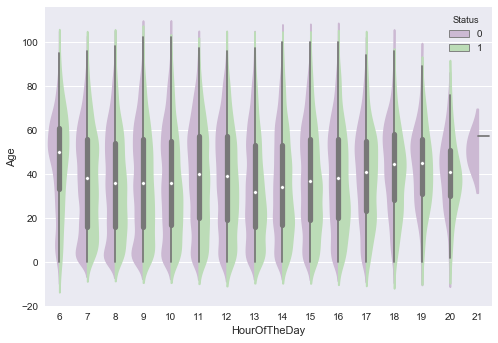

In [164]:
# Trend for preference of the hour of day by age 

sns.violinplot(x='HourOfTheDay',y='Age',hue='Status',data=df_final, palette='PRGn',split=True)

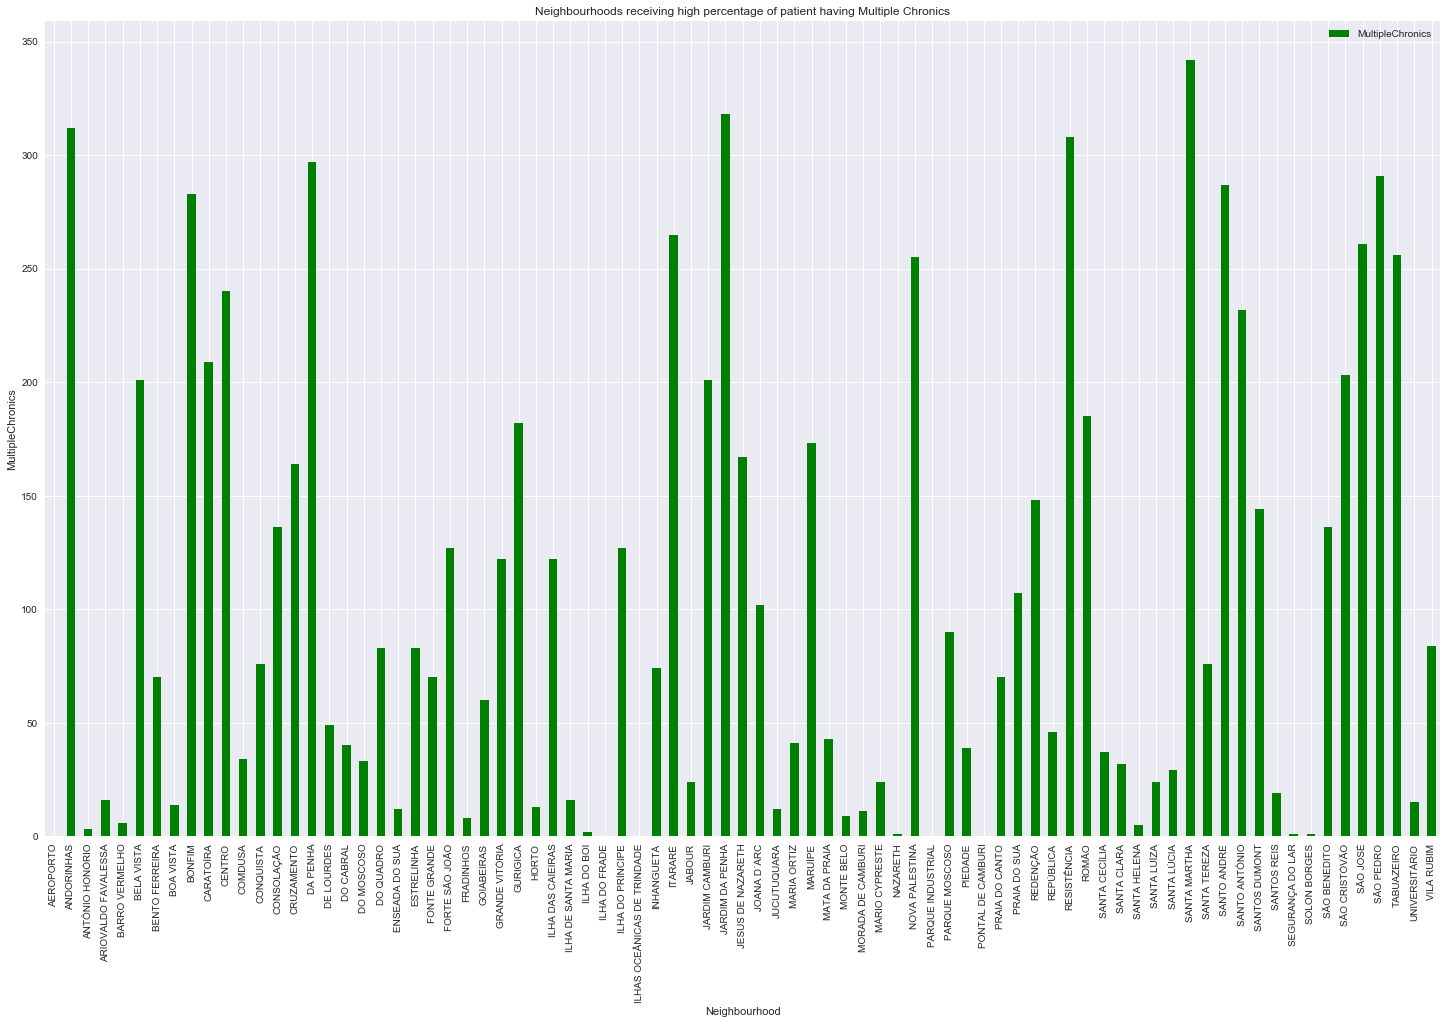

In [168]:
# Which Neighbourhood is receiving high percentage of patient having Multiple Chronics
data = df_final[['Neighbourhood','MultipleChronics']]
Sum=data.groupby('Neighbourhood').sum()
Sum.plot(kind='bar',figsize=(25,15),title='Neighbourhoods receiving high percentage of patient having Multiple Chronics',color = 'green')
plt.ylabel('MultipleChronics')

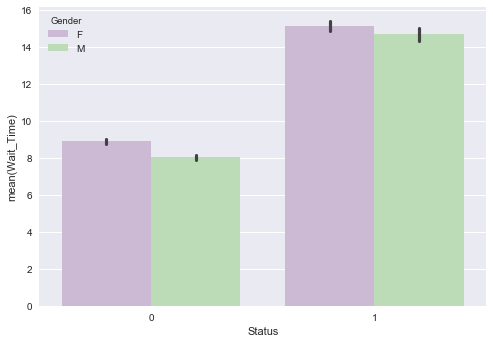

In [169]:
# Trend for mean wait time

sns.barplot(x='Status', y='Wait_Time',hue='Gender', data=df_final, palette='PRGn')

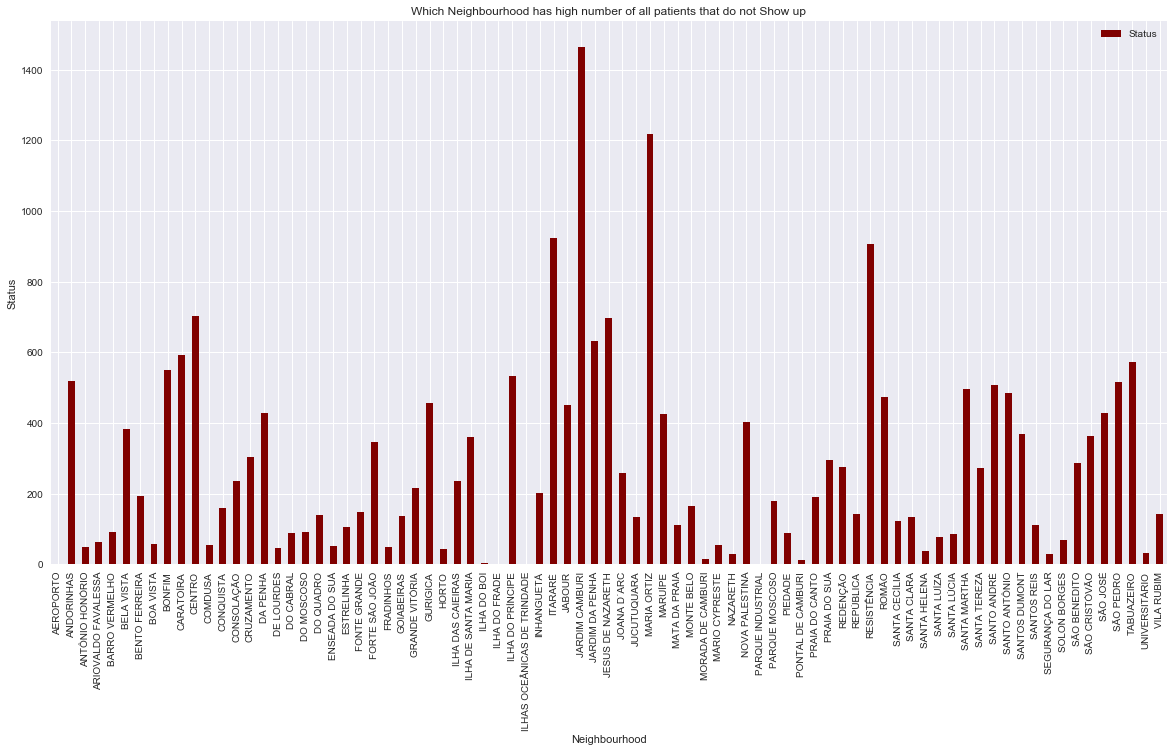

In [170]:
#Which neighborhood has high number of patients with no-show?

data = df_final[['Neighbourhood','Status']]
Neighbourhood_group = data.groupby('Neighbourhood')
Sum = Neighbourhood_group.sum()
Sum.sort_values('Status',ascending=True)
Sum.plot(kind='bar',figsize=(20, 10),color = 'maroon', title='Which Neighbourhood has high number of all patients that do not Show up')
plt.ylabel("Status")
plt.xlabel("Neighbourhood")


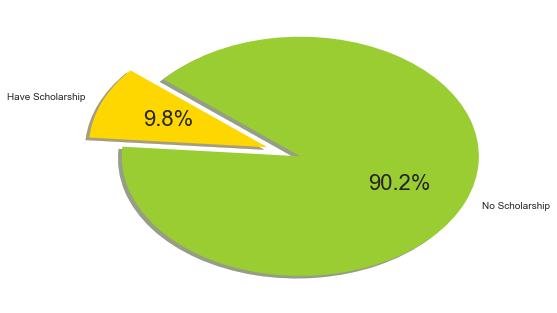

In [171]:
#What percent of patients have scholarship and do not show-up?

total_of_patient=len(df)
no_scholarship, has_scholarship = df['Scholarship'].value_counts()
#extract patients who have scholarship
df_schol = df.loc[df['Scholarship'] == 1]

yes, no = df_schol['Status'].value_counts()
per_no_show_with_scholarship = no/has_scholarship*100
per_show_with_scholarship = yes/has_scholarship*100

#plot people who have/not have scholarship 
labels = 'Have Scholarship', 'No Scholarship'
sizes = [has_scholarship, no_scholarship]
colors = ['gold', 'yellowgreen']
explode = (0.2, 0)
A = plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)


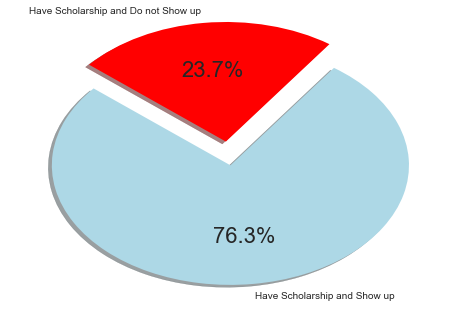

In [172]:
#Plot to show people who have scholarship and show up or not show up
labels1 = 'Have Scholarship and Show up', 'Have Scholarship and Do not Show up'
sizes1 = [yes, no]
colors1 = ['lightblue', 'red']
explode1 = (0, 0.2)
B = plt.pie(sizes1, explode=explode1, labels=labels1, colors=colors1,
        autopct='%1.1f%%', shadow=True, startangle=140)

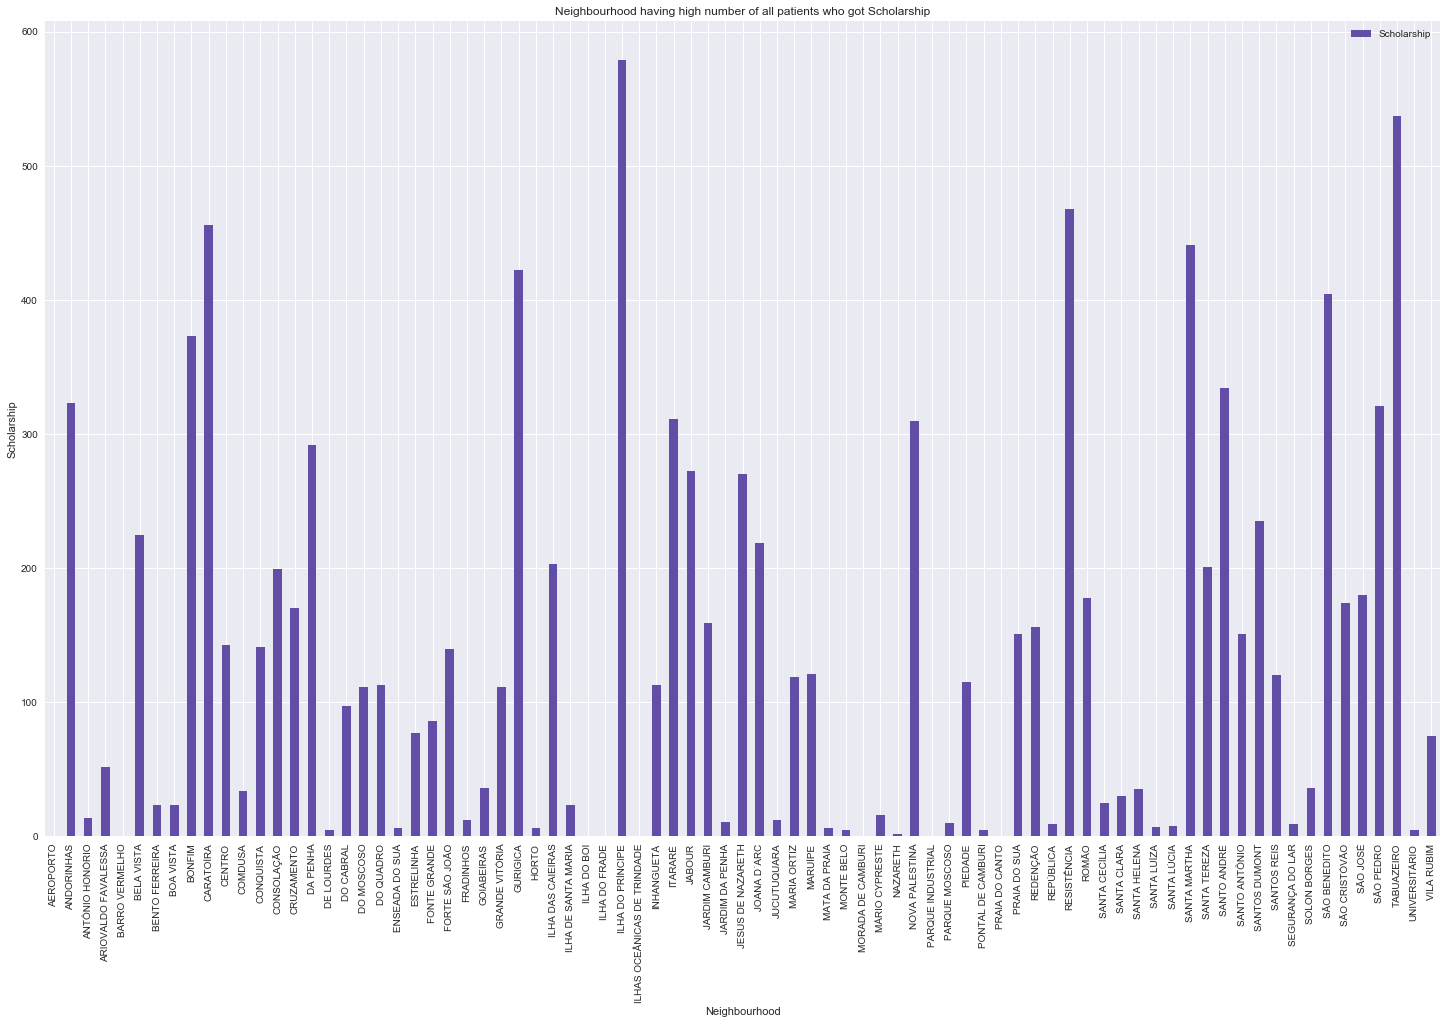

In [173]:
#Which Neighbouthood has a high number of patients with Scholarship
data = df_final[['Neighbourhood','Scholarship']]
colors = ['#624ea7', 'g', 'yellow', 'k', 'maroon']
Group_by_Neighbourhood = data.groupby(['Neighbourhood'])
Sum = Group_by_Neighbourhood.sum()
Sum.sort_values('Scholarship',ascending=True)
Sum.plot(kind='bar',color=colors,figsize=(25, 15),title='Neighbourhood having high number of all patients who got Scholarship')
plt.xlabel("Neighbourhood")
plt.ylabel("Scholarship")

Prediction of a Patient Showing/Not Showing up for an Appointment
In all the classifiers, we have sampled the data into train and test set, the ratio being 80:20

In [174]:
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.metrics import roc_curve,auc,precision_score, recall_score,f1_score,confusion_matrix


# define plot for roc curve

def roc_curve_plot(fpr, tpr,roc_auc, title='Receiver Operating Characteristic'):
    plt.plot(fpr, tpr,linewidth=2, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()


# we will use ROC AUC to asses the model because of the unbalanced nature of dataset ~80% data belonging to negative class

def assess_model(scores,true_y,prediction,prediction_roc,label=None):
    print("Assess",label,":")
    print("Accuracy measure for",label, "using cross validation ",scores.mean())
    print("Confusion matrix \n", confusion_matrix(true_y, prediction))
    print("Precision score",precision_score(true_y, prediction))
    print("Recall score",recall_score(true_y, prediction))
    print("F1 score",f1_score(true_y, prediction))
    
    fpr,tpr,threshold=roc_curve(true_y,prediction_roc)
    roc_auc = auc(fpr,tpr)
    roc_curve_plot(fpr,tpr,roc_auc,"Receiver Operating Characteristic for " + label)


For Random classifier, we had stored our pre-processed data in the file Medical_Appointment_Data.csv

In [175]:
df_data=pd.read_csv("Medical_Appointment_Data.csv",encoding="iso-8859-1")
df_data.head()

,Unnamed: 0,PatientId,Gender,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No-show,DayofWeek,HourOfTheDay,Wait_Time,MultipleChornics,Labeled_Neighbourhood
0,100517,1,F,44,PRAIA DO SUÁ,0,0,0,0,0,0,No,Friday,10,2,0,1
1,105430,2,M,39,MARIA ORTIZ,0,0,1,0,0,0,No,Wednesday,14,1,0,2
2,3950,3,F,33,CENTRO,0,0,0,0,0,0,No,Wednesday,9,1,0,3
3,73303,4,M,12,FORTE SÃO JOÃO,0,0,0,0,0,0,No,Monday,7,2,0,4
4,73228,5,F,14,FORTE SÃO JOÃO,0,0,0,0,0,1,No,Friday,7,6,0,4


In [176]:
#Replace Yes and No values for No-Show to 1 and 0 respectively
df_data['No-show'].replace("No", 0,inplace=True)
df_data['No-show'].replace("Yes",1,inplace=True)

# Creating a new field to capture appointments missed by patients
df_data['App_Missed'] = df_data.groupby('PatientId')['No-show'].apply(lambda x: x.cumsum())

# Drop the following columns and Neighborhood which has 81 different categories
df_data.drop(df_data.columns[0],axis=1,inplace=True)
df_data.drop(["PatientId","Labeled_Neighbourhood","Neighbourhood"],axis=1,inplace=True)

X=df_data.loc[:,df_data.columns!='No-show']
y=df_data.loc[:,df_data.columns=='No-show']

# Convert all categorical data to its one-hot encoding representaition
catgories=["Gender","Handicap","DayofWeek"]
X=pd.get_dummies(X, columns=catgories)


In [177]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.20)

# convert y to 1-D array as required by the classifiers
y_train=np.ravel(y_train)
y_test=np.ravel(y_test)

print("Train No-Show proportion",(sum(y_train==1)/len(y_train))*100)
print("Test No-Show proportion",(sum(y_test==1)/len(y_test))*100)


Train No-Show proportion 20.2734799131
Test No-Show proportion 19.8642840986


Winner Algorithm-Random Forest Classifier

Assess Random Forest  :
Accuracy measure for Random Forest  using cross validation  0.91487967241
Confusion matrix 
 [[66077  4414]
 [ 3112 14813]]
Precision score 0.770427003693
Recall score 0.826387726639
F1 score 0.797426787252


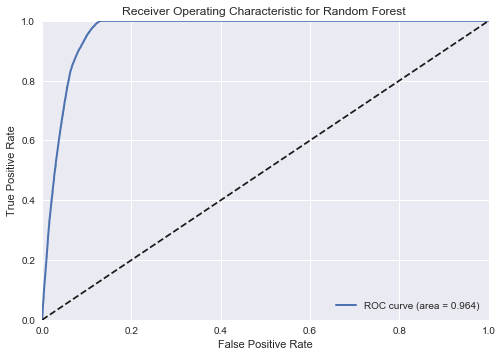

In [178]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=15,max_depth=10)

rf_clf.fit(X_train,y_train)

# cross validation for random forest
y_scores = cross_val_score(rf_clf, X_train, y_train, cv=5,scoring="accuracy")
y_predict_rf=cross_val_predict(rf_clf, X_train, y_train, cv=5)
y_predict_rf_roc=cross_val_predict(rf_clf, X_train, y_train, cv=5,method="predict_proba")


# Now call the asses function
# Validate the model on the training set using cross validation technique to analyse the results...

assess_model(y_scores,y_train,y_predict_rf,y_predict_rf_roc[:,1],"Random Forest ")

Here a Gaussian Naive Bayes Classifier is implemented.

In [179]:
from sklearn.naive_bayes import GaussianNB

x_cols = ["Age", "Scholarship","Hypertension","Diabetes","Alcoholism","Handicap","Wait_Time","Num_App_Missed"]
df_clf = df_final[x_cols]


Full_data = np.array(df_clf)
target_data = np.array(df_final['Status'])

X_train, X_test, y_train, y_test = train_test_split(Full_data, target_data, test_size=0.20, random_state=0)

gnb_clf = GaussianNB()
gnb_clf.fit(X_train, y_train)
val_Y_Prediction = gnb_clf.predict(X_test)
print("Accuracy", accuracy_score(y_test,val_Y_Prediction))


Accuracy 0.825016964488


Assess Gaussian Naive Bayes Classifier :
Accuracy measure for Gaussian Naive Bayes Classifier using cross validation  0.825959080206
Confusion matrix 
 [[66651  3944]
 [11444  6377]]
Precision score 0.617866485806
Recall score 0.357836260591
F1 score 0.453201620354


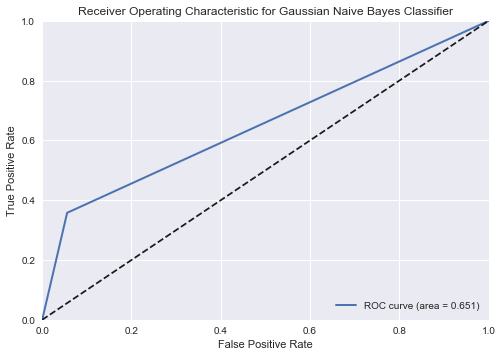

In [180]:
y_scores=cross_val_score(gnb_clf, X_train, y_train, cv=5,scoring="accuracy")

y_predict_gnb = cross_val_predict(gnb_clf, X_train, y_train, cv=5)

assess_model(y_scores,y_train,y_predict_gnb,y_predict_gnb,"Gaussian Naive Bayes Classifier")

Third Classifier is K-Nearest Neighbor Classifier. This was the second best classifier.

In [181]:
#KNeighborsClassifier
from sklearn import neighbors, datasets

x_cols = ["MultipleChronics","Wait_Time","Num_App_Missed","SMS_received"]
x_cols
df_clf = df_final[x_cols]
# df_clf
Full_data = np.array(df_clf)
target_data = np.array(df_final['Status'])
X_train, X_test, y_train, y_test = train_test_split(Full_data, target_data, test_size=0.20, random_state=0)
 # Split iris data in train and test data

from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train) 
KNeighborsClassifier(algorithm='auto', leaf_size=20, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')
y_predict = knn_clf.predict(X_test)
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, y_predict))

0.907758425696


Assess KNeighborsClassifier :
Accuracy measure for KNeighborsClassifier using cross validation  0.902167139829
Confusion matrix 
 [[65083  5512]
 [ 3138 14683]]
Precision score 0.727061153751
Recall score 0.823915605185
F1 score 0.772464225589


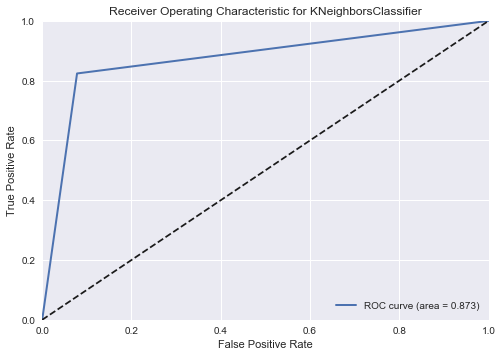

In [182]:
y_scores=cross_val_score(knn_clf, X_train, y_train, cv=5,scoring="accuracy")

y_predict_knn = cross_val_predict(knn_clf, X_train, y_train, cv=5)

assess_model(y_scores,y_train,y_predict_knn,y_predict_knn,"KNeighborsClassifier")

This concludes the Data Exploration and Prediction.